## Часть 3. Проверка гипотез

При анализе сгруппированного по артистам датасета была выявлена положительная корреляция между количеством средним количеством прослушиваний одного трека у артиста и количества треков у артиста. 

Попробуем проверить гипотезу о положительном влиянии количества треков на прослушивания с помощью линейной регрессии логарифма количества прослушиваний на количество треков, и некоторые базовые характеристики композиций:

* **H0:** Количество треков не влияет на среднее количество прослушиваний трека
* **H1:** Влияние есть
   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
dfg = pd.read_csv('spotify_EDA_g.csv')

В сгруппированном датасете переменная track - количество треков у артиста, album - количество альбомов у артиста, остальные харакетиристики усредненные по количеству треков:

In [3]:
dfg.head()

,Unnamed: 0,artist,track,album,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,stream,ln_stream
0,0,$NOT,10,7,0.758000,0.634300,6.100000,-7.297400,0.214700,0.259997,0.026274,0.199710,0.498050,117.551800,2.695383,1.127638e+08,18.540806
1,1,$uicideboy$,10,9,0.796600,0.683200,5.400000,-6.525800,0.141590,0.161158,0.000728,0.149230,0.337930,116.809000,2.734050,2.126748e+08,19.175275
2,2,(G)I-DLE,10,8,0.691400,0.815300,5.400000,-3.756900,0.096790,0.029762,0.000009,0.208640,0.476000,122.914300,3.151802,1.304212e+08,18.686280
3,3,*NSYNC,10,4,0.622400,0.769700,7.100000,-5.798000,0.057520,0.154031,0.000177,0.266430,0.687400,131.879900,3.925645,1.427834e+08,18.776839
4,4,070 Shake,9,7,0.575222,0.687333,3.111111,-6.526111,0.114878,0.065130,0.005138,0.124967,0.236278,126.649111,3.732509,4.503116e+07,17.622865


In [5]:
X = dfg[['track', 'loudness', 'duration_min']].copy()
y = dfg['ln_stream'].copy()

X1 = sm.add_constant(X) # Добавляем константу, чтобы был свободный член
model = sm.OLS(y, X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_stream   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     42.56
Date:                Sat, 10 May 2025   Prob (F-statistic):           1.14e-26
Time:                        22:43:54   Log-Likelihood:                -3020.8
No. Observations:                2028   AIC:                             6050.
Df Residuals:                    2024   BIC:                             6072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.6643      0.261     67.617   

При переменных track, loudness значимые коэффициенты:

* **При увеличении количества треков на 1 среднее количество прослушиваний растет на ~9%**
* **У артиста со средней громкостью треков большей на 1 дБ среднее количество прослушиваний трека выше на ~4.7%**
    
    *(нелинейная связь из-за того, что зависимая переменная это логарифм)*
    
Однако объясняющая сила модели крайне мала, исправленный R-квадрат на уровне 5.8% это очень маленькое значение.
Попробуем добавить в модель остальные переменные:

In [9]:
X = dfg.drop(['Unnamed: 0', 'artist', 'ln_stream', 'stream', 'album'], axis = 1)
y = dfg['ln_stream'].copy()

X1 = sm.add_constant(X) # Добавляем константу, чтобы был свободный член
model = sm.OLS(y, X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_stream   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     29.76
Date:                Sat, 10 May 2025   Prob (F-statistic):           2.76e-63
Time:                        23:03:12   Log-Likelihood:                -2917.4
No. Observations:                2028   AIC:                             5861.
Df Residuals:                    2015   BIC:                             5934.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               21.7612      0.549  

R-квадрат вырос, однако все еще очень мал. При этом в модели возможно присутствует мультиколлинеарность. Построим корреляционную матрицу признаков:

<AxesSubplot:>

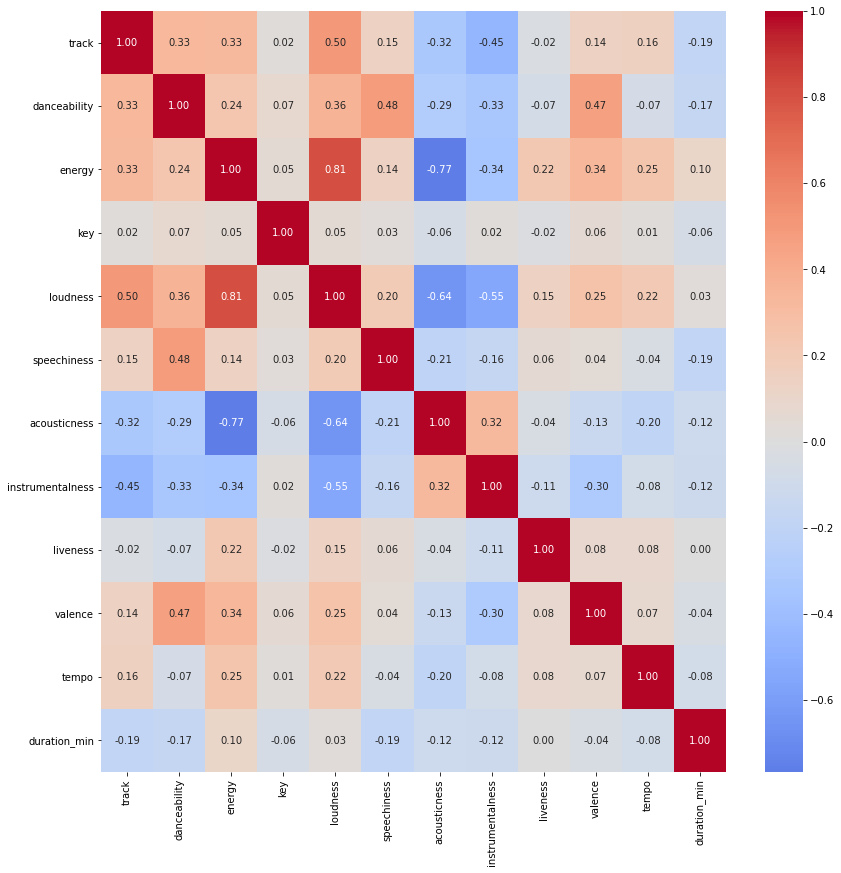

In [10]:
plt.figure(figsize = (14,14))
sns.heatmap(X.corr(), annot = True, cmap = "coolwarm", center = 0, fmt = ".2f")

Действительно, между многими признаками есть попарная корреляция. При этом большинство переменных это индексы, построенные на одних и тех же музыкальных характеристиках, вследствие чего между ними есть смысловая взаимосвязь, например:
1. Чем выше acousticness, тем ниже energy
2. Чем выше instrumentalness, тем ниже energy

Таким образом, трудно выявить комбинации признаков, которые будут улучшать качество модели и при этом не быть коррелированы между собой. Только с базовыми харакетиристиками композиций модель не имеет высокой предсказательной силы, однако при добавлении остальных переменных мы рискуем сместить оценку коэффициентов при отдельных переменных из-за плохого разделения эффекта между ними.

Опробовав различные комбинации признаков, а также их попарных произведений удалось повысить R-квадрат до ~20%, однако модель теряет смысл в силу большого количества переменных, подозрения на мультиколлинеарность и отсутствия логического объяснения для отдельных переменных:

In [12]:
def create_products(df, columns):
    df1 = df.copy()
    for i in range(len(columns)):
        for k in range (i+1, len(columns)):
            df1[f'{columns[i]}_x_{columns[k]}'] = df1[columns[i]] * df1[columns[k]]
    return df1 # Возвращаем датафрейм с попарными произведениями

def reg(df, y):
    X1 = sm.add_constant(df) # Добавим константу, чтобы был свободный член
    model = sm.OLS(y, X1) 
    results = model.fit() 
    print(results.summary()) # Cмотрим результат
    return results

In [20]:
dfg2 = dfg.drop(['ln_stream', 'stream', 'Unnamed: 0', 'artist'], axis = 1).copy()
dfg3 = create_products(dfg2, dfg2.columns)
drop_list = ['danceability',
             'energy',
             'loudness',
             'speechiness',
             'instrumentalness',
             'liveness',
             'valence',
             'tempo',
             'duration_min',
             'track_x_album',
             'track_x_danceability',
             'track_x_energy',
             'track_x_key',
             'track_x_loudness',
             'track_x_instrumentalness',
             'track_x_liveness',
             'track_x_valence',
             'track_x_tempo',
             'track_x_duration_min',
             'album_x_danceability',
             'album_x_key',
             'album_x_speechiness',
             'album_x_instrumentalness',
             'album_x_liveness',
             'album_x_valence',
             'album_x_tempo',
             'danceability_x_energy',
             'danceability_x_key',
             'danceability_x_speechiness',
             'danceability_x_instrumentalness',
             'danceability_x_liveness',
             'danceability_x_valence',
             'danceability_x_tempo',
             'danceability_x_duration_min',
             'energy_x_key',
             'energy_x_loudness',
             'energy_x_acousticness',
             'energy_x_instrumentalness',
             'energy_x_liveness',
             'energy_x_tempo',
             'energy_x_duration_min',
             'key_x_speechiness',
             'key_x_acousticness',
             'key_x_instrumentalness',
             'key_x_valence',
             'key_x_tempo',
             'key_x_duration_min',
             'loudness_x_acousticness',
             'loudness_x_instrumentalness',
             'loudness_x_liveness',
             'loudness_x_tempo',
             'loudness_x_duration_min',
             'speechiness_x_acousticness',
             'speechiness_x_instrumentalness',
             'speechiness_x_tempo',
             'acousticness_x_instrumentalness',
             'acousticness_x_liveness',
             'acousticness_x_tempo',
             'acousticness_x_duration_min',
             'instrumentalness_x_liveness',
             'instrumentalness_x_valence',
             'instrumentalness_x_tempo',
             'liveness_x_valence',
             'liveness_x_tempo',
             'liveness_x_duration_min',
             'valence_x_tempo',
             'valence_x_duration_min',
             'tempo_x_duration_min']
dfg3 = dfg3.drop(drop_list, axis = 1)

In [21]:
reg(dfg3, y)

                            OLS Regression Results                            
Dep. Variable:              ln_stream   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     23.74
Date:                Sat, 10 May 2025   Prob (F-statistic):           4.07e-88
Time:                        23:24:57   Log-Likelihood:                -2838.6
No. Observations:                2028   AIC:                             5725.
Df Residuals:                    2004   BIC:                             5860.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Поскольку это модель с наилучшим R-квадрат, и в ней переменная track сама по себе не имеет значимого коэффициента, гипотезу о наличии линейной зависимости между логарифмом среднего числа прослушиваний трека и количеством треков у артиста отклоняем, и принимаем H0.

**Вывод:**
* **Принимаем H0, значимой линейной взаимосвязи не наблюдается**

Несмотря на это, в реальности взаимосвязь действительно может быть, но нелиейная, либо в модели не хватает важных регрессоров, которые позволили бы повысить ее точность и выявить влияние.